In [1]:
!pip3 install torch torchvision

In [2]:
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE: int = 100
EPOCHS: int = 15
LEARNING_RATE: float = 0.001

In [4]:
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

In [5]:
transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

In [6]:
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [8]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

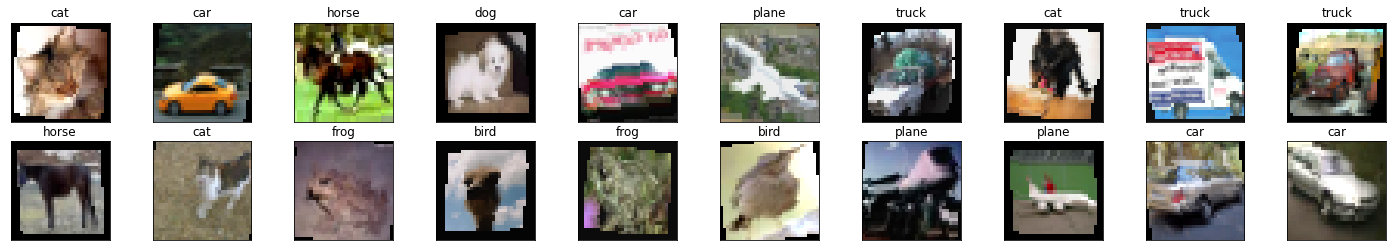

In [9]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [10]:
class LeNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
      self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
      self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
      self.fc1 = nn.Linear(4*4*64, 500)
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(500, 10)
      
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2) 
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, 2, 2)
      x = torch.flatten(x, start_dim=1)
      #x = x.view(-1, 4*4*64)
      x = F.relu(self.fc1(x))
      x = self.dropout1(x)
      x = self.fc2(x)
      return x

In [11]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [14]:
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
for e in tqdm(range(EPOCHS)):
  model.train()
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    model.eval()
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
    
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

  7%|▋         | 1/15 [00:43<10:02, 43.01s/it]

epoch : 1
training loss: 1.6900, acc 37.9160 
validation loss: 1.3590, validation acc 50.4500 


 13%|█▎        | 2/15 [01:24<09:14, 42.69s/it]

epoch : 2
training loss: 1.4031, acc 49.2360 
validation loss: 1.2091, validation acc 56.3500 


 20%|██        | 3/15 [02:06<08:27, 42.32s/it]

epoch : 3
training loss: 1.2800, acc 54.0280 
validation loss: 1.0843, validation acc 61.1700 


 27%|██▋       | 4/15 [02:46<07:39, 41.76s/it]

epoch : 4
training loss: 1.1825, acc 58.0780 
validation loss: 0.9819, validation acc 64.8200 


 33%|███▎      | 5/15 [03:28<06:56, 41.64s/it]

epoch : 5
training loss: 1.1090, acc 60.7140 
validation loss: 0.9706, validation acc 65.5000 


 40%|████      | 6/15 [04:08<06:10, 41.21s/it]

epoch : 6
training loss: 1.0638, acc 62.5040 
validation loss: 0.9245, validation acc 67.0300 


 47%|████▋     | 7/15 [04:49<05:29, 41.19s/it]

epoch : 7
training loss: 1.0201, acc 64.1400 
validation loss: 0.8731, validation acc 69.7200 


 53%|█████▎    | 8/15 [05:30<04:47, 41.08s/it]

epoch : 8
training loss: 0.9813, acc 65.7340 
validation loss: 0.8309, validation acc 71.2400 


 60%|██████    | 9/15 [06:10<04:05, 40.85s/it]

epoch : 9
training loss: 0.9586, acc 66.3500 
validation loss: 0.8260, validation acc 71.6700 


 67%|██████▋   | 10/15 [06:50<03:22, 40.56s/it]

epoch : 10
training loss: 0.9257, acc 67.6280 
validation loss: 0.8101, validation acc 71.3400 


 73%|███████▎  | 11/15 [07:31<02:42, 40.52s/it]

epoch : 11
training loss: 0.9091, acc 68.2360 
validation loss: 0.7734, validation acc 72.8700 


 80%|████████  | 12/15 [08:11<02:01, 40.38s/it]

epoch : 12
training loss: 0.8852, acc 69.1580 
validation loss: 0.7563, validation acc 73.3800 


 87%|████████▋ | 13/15 [08:51<01:20, 40.43s/it]

epoch : 13
training loss: 0.8703, acc 69.6380 
validation loss: 0.7519, validation acc 73.5600 


 93%|█████████▎| 14/15 [09:32<00:40, 40.42s/it]

epoch : 14
training loss: 0.8568, acc 70.1380 
validation loss: 0.7273, validation acc 74.6800 


100%|██████████| 15/15 [10:13<00:00, 40.90s/it]

epoch : 15
training loss: 0.8441, acc 70.7020 
validation loss: 0.7148, validation acc 75.2200 


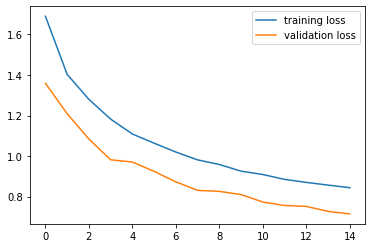

In [15]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()